In [38]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from segmentation_evaluator import NoduleSegmentEvaluator, compute_volume_voxel_count
from tqdm import tqdm
import json

In [39]:
def plot_distributions(all_intensities, mask_intensities, volumes, num_nodules_per_scan, thicknesses, num_slices, dataset_name):
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()

    axs[0].hist(all_intensities, bins=100, color='blue', alpha=0.7)
    axs[0].set_title(f"Mean Normalized Pixel Intensities [N = {len(all_intensities)}]")

    axs[1].hist(mask_intensities, bins=100, color='blue', alpha=0.7)
    axs[1].set_title(f"Mean Normalized Pixel Intensities of Annotated Regions [N = {len(mask_intensities)}]")

    axs[2].hist(volumes, bins=50, color='green', alpha=0.7)
    axs[2].set_title(f"True Nodule Volumes (mm³) [N = {len(volumes)}]")

    axs[3].hist(num_nodules_per_scan, bins=50, color='orange', alpha=0.7)
    axs[3].set_title(f"Number of True Nodules per Scan [N = {len(num_nodules_per_scan)}]")

    axs[4].hist(thicknesses, bins=30, color='purple', alpha=0.7)
    axs[4].set_title(f"Slice Thicknesses (mm) [N = {len(thicknesses)}]")

    axs[5].hist(num_slices, bins=30, color='red', alpha=0.7)
    axs[5].set_title(f"Number of Slices per Scan [N = {len(num_slices)}]")

    # axs[6].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join("/data/scratch/erubel/nlst/v2/figures/datasets", dataset_name))

In [40]:
def remove_outliers(data, factor=1.5):
    """Remove outliers using the IQR method."""

    data = [val for val in data if not pd.isna(val)]

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return [x for x in data if lower <= x <= upper]

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

# Example data
data = {
    "LUNA16": json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/Dataset082_Luna_stats.json")),
    "LNDb": json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/Dataset081_Lndb_stats.json")),
    "UTC": json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/Dataset083_Utc_stats.json")),
    "NLST": json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/niftis_stats_no_cancer_and_cancer.json")),
    # "NLST": json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/niftis_stats.json")) | json.load(open("/data/scratch/erubel/nlst/v2/figures/datasets/niftis_stats_cancer_only.json")),
}

label_mapping1 = {
    "mask_ints": "Mean Normalized Pixel Intensities of Annotated Regions",
    "vols": "True Nodule Volumes (mm³)",
    "num_nodules_per_scan": "Number of True Nodules per Scan",
}

label_mapping2 = {
    "all_ints": "Mean Normalized Pixel Intensities",
    "thick": "Slice Thicknesses (mm)",
    "slices": "Number of Slices per Scan",
}

dataset_to_color = {
    "LUNA16": "#99FF99",  # pastel green
    "LNDb":   "#FF9999",  # pastel red
    "UTC":    "#99CCFF",  # pastel blue
    "NLST":   "#FFD699",  # pastel orange
}

/tmp/ipykernel_1240594/3820996755.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[g["Value"].isin(remove_outliers(g["Value"].tolist()))])
/tmp/ipykernel_1240594/3820996755.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=cleaned_df, x="Dataset", y="Value", ax=ax, inner="box", palette=dataset_to_color, order=dataset_order)
/tmp/ipykernel_1240594/3820996755.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping 

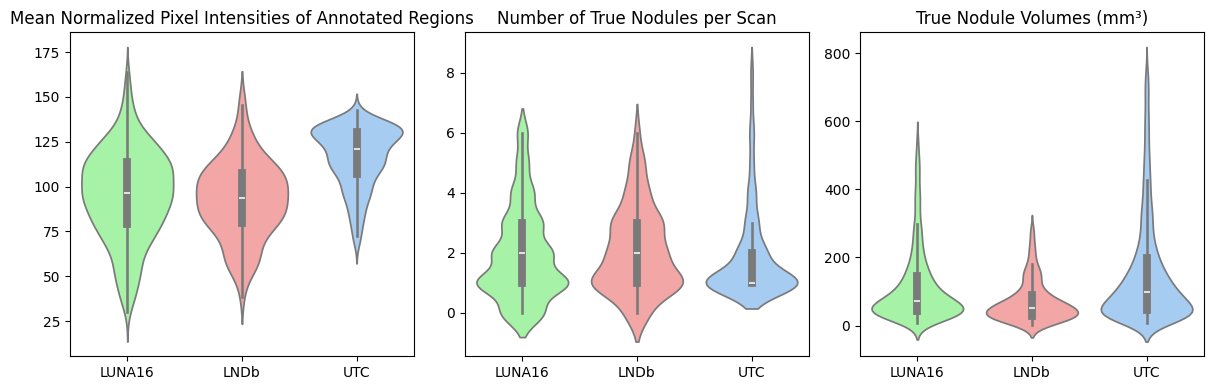

In [42]:
dataset_order = ["LUNA16", "LNDb", "UTC"]

rows = []
for dataset, stats in data.items():
    for key, values in stats.items():
        if key in label_mapping1:
            for v in values:
                rows.append({"Dataset": dataset, "Metric": label_mapping1.get(key, ""), "Value": v})

df = pd.DataFrame(rows)

metrics = df["Metric"].unique()
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    # sns.boxplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, palette=dataset_to_color)
    # sns.boxplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, showfliers=False, palette=dataset_to_color)
    # ax.set_yscale('log')
    cleaned_df = (
        df[df["Metric"] == metric].groupby("Dataset", group_keys=False)
        .apply(lambda g: g[g["Value"].isin(remove_outliers(g["Value"].tolist()))])
    )
    sns.violinplot(data=cleaned_df, x="Dataset", y="Value", ax=ax, inner="box", palette=dataset_to_color, order=dataset_order)
    ax.set_title(metric.replace("_", " "))
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

      Dataset                             Metric       Value
0      LUNA16  Mean Normalized Pixel Intensities   80.481883
1      LUNA16  Mean Normalized Pixel Intensities   59.263076
2      LUNA16  Mean Normalized Pixel Intensities   76.964485
3      LUNA16  Mean Normalized Pixel Intensities   65.530946
4      LUNA16  Mean Normalized Pixel Intensities   60.003222
...       ...                                ...         ...
17305    NLST          Number of Slices per Scan  235.000000
17306    NLST          Number of Slices per Scan  224.000000
17307    NLST          Number of Slices per Scan  154.000000
17308    NLST          Number of Slices per Scan  171.000000
17309    NLST          Number of Slices per Scan  167.000000

[17310 rows x 3 columns]


/tmp/ipykernel_1240594/1910947946.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, inner="box", palette=dataset_to_color)
/tmp/ipykernel_1240594/1910947946.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, inner="box", palette=dataset_to_color)
/tmp/ipykernel_1240594/1910947946.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, inner="

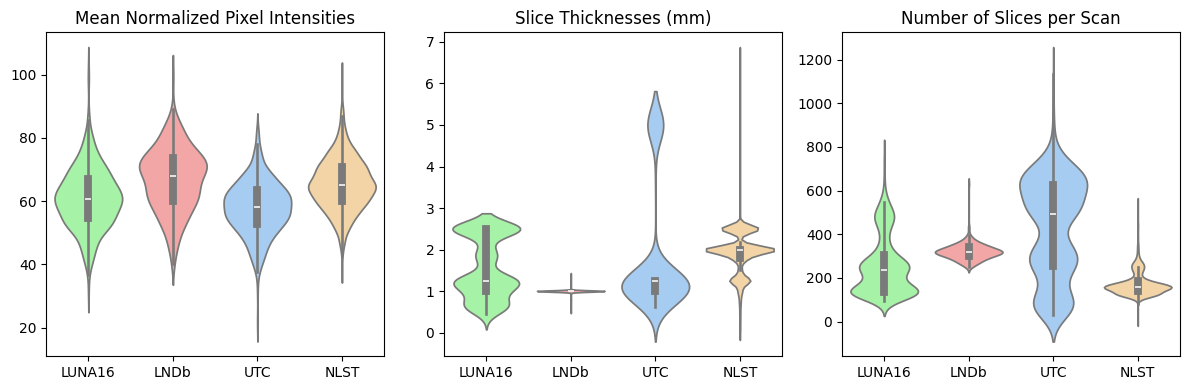

In [43]:
rows = []
for dataset, stats in data.items():
    for key, values in stats.items():
        if key in label_mapping2:
            for v in values:
                rows.append({"Dataset": dataset, "Metric": label_mapping2.get(key, ""), "Value": v})

df = pd.DataFrame(rows)

print(df)

metrics = df["Metric"].unique()
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    # sns.boxplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, showfliers=False, palette=dataset_to_color)
    sns.violinplot(data=df[df["Metric"] == metric], x="Dataset", y="Value", ax=ax, inner="box", palette=dataset_to_color)
    ax.set_title(metric.replace("_", " "))
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()